This notebook implements a music genre classification algorithm using the GTZAN dataset from Kaggle. The goal of this project is to classify audio clips into 10 possible genres using 2 separate approaches. We will attempt to create a model using extracted audio features from the .wav files, as well as a model using an image-based approach which works by comparing spectrograms. Then, we will compare these approaches to evaluate performance and find the most effective method of the two.

In [1]:
# import our libraries
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display as lplt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

/var/folders/b0/5zpzyj6d01ldf7ckz3qfk5wc0000gn/T/ipykernel_79170/1154135929.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading and Preliminary Inspecting of Data

In [2]:
df = pd.read_csv('data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
# print the row and column count
print('The dataset has %d Rows and %d Columns.' % (df.shape[0], df.shape[1]))

The dataset has 9990 Rows and 60 Columns.


In [4]:
# investigate the columns names
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [5]:
# we take an arbitrary song in order to investigate the plot
audio_path = 'data/genres_original/hiphop/hiphop.00000.wav'
audio_data, sr = librosa.load(audio_path, sr = None)

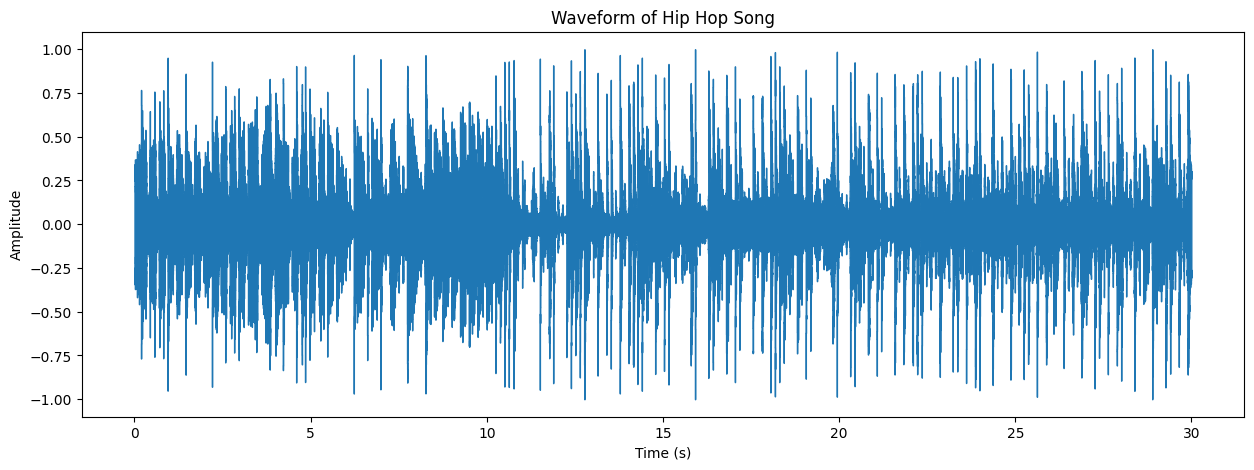

In [6]:
# plot the waveform of one of the selected hip hop songs
plt.figure(figsize = (15, 5))
lplt.waveshow(audio_data, sr = sr)
plt.title('Waveform of Hip Hop Song')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

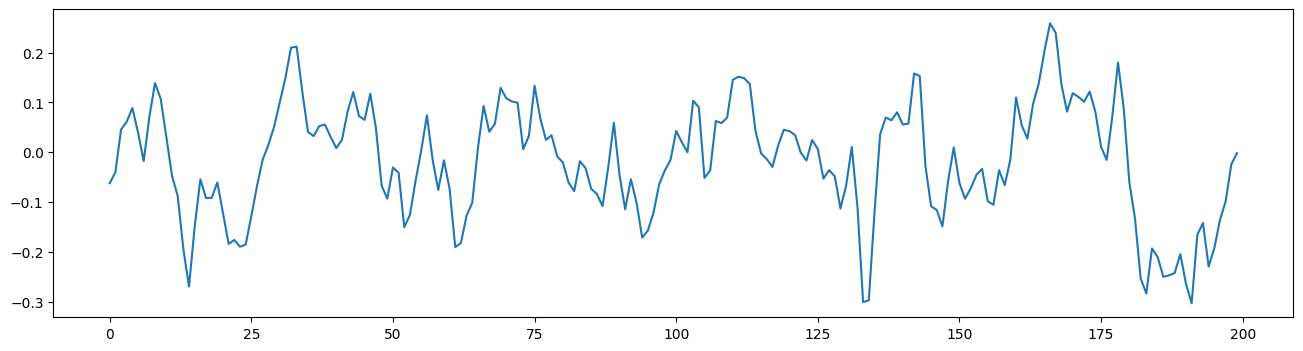

In [7]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

### Exploratory Data Analysis

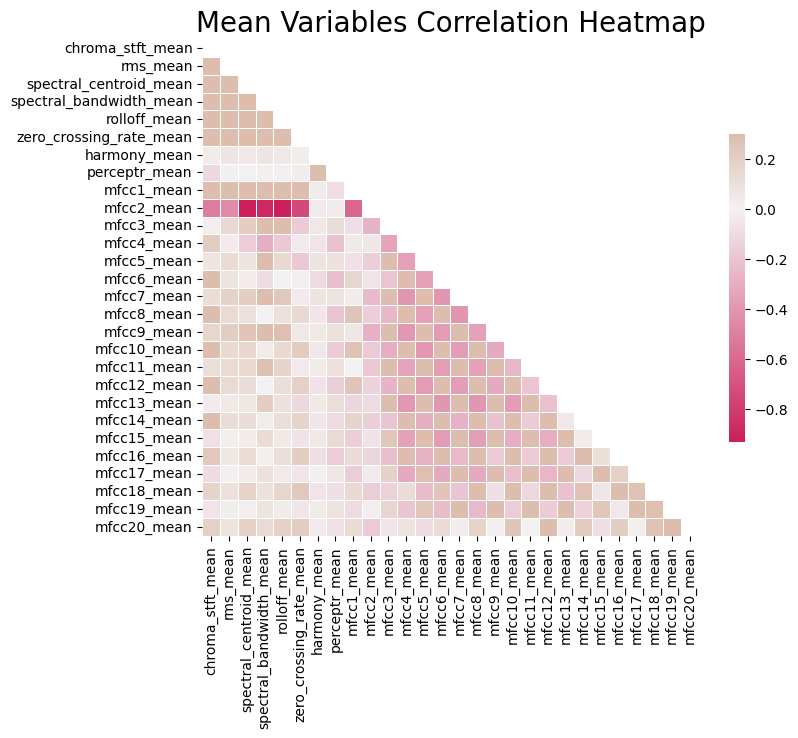

In [8]:
# computing the correlation matrix for the means
cols = [col for col in df.columns if 'mean' in col]
correlation = df[cols].corr()

mask = np.triu(np.ones_like(correlation, dtype = bool))

f, ax = plt.subplots(figsize = (8, 8))
cmap = sns.diverging_palette(0, 25, as_cmap = True, s = 90, l = 45, n = 5)

sns.heatmap(correlation, mask = mask, cmap = cmap, vmax = 0.3, center = 0, square = True, linewidths = 0.5, cbar_kws = {'shrink': 0.5})

plt.title('Mean Variables Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")
plt.show()

/var/folders/b0/5zpzyj6d01ldf7ckz3qfk5wc0000gn/T/ipykernel_79170/755672038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'label', y = 'tempo', data = x, palette = 'husl')


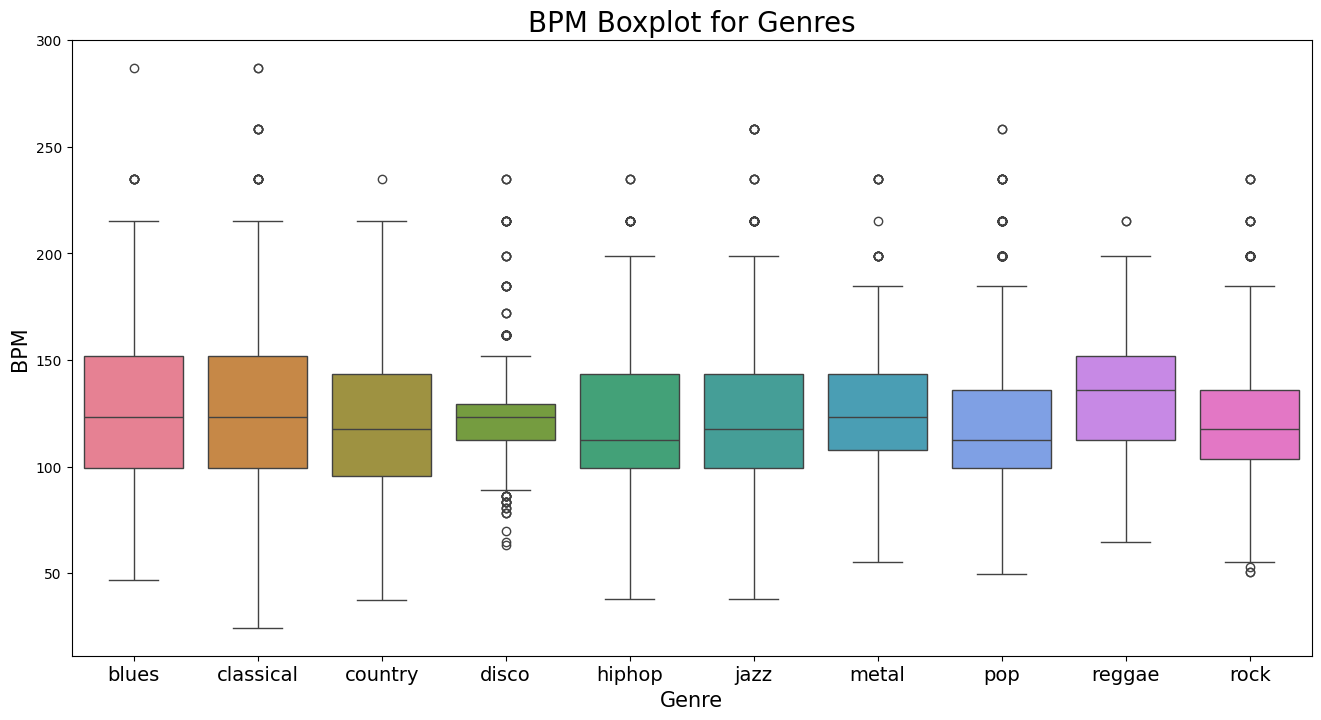

In [9]:
# we create a boxplot of the BPMs for our 10 genres
x = df[['label', 'tempo']]

fig, ax = plt.subplots(figsize = (16, 8))
sns.boxplot(x = 'label', y = 'tempo', data = x, palette = 'husl')

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel('Genre', fontsize = 15)
plt.ylabel('BPM', fontsize = 15)
plt.savefig('BPM_Boxplot.png')

The boxplot compares BPM distributions across our 10 music genre classes. Each box on our plot shows the median, quartiles, and the spread of BPM values, with the dots representing outlier values. Here, we're able to see differences in tempo characteristics amongst different genres.

In [10]:
# here, we map all of our labels onto numeric values and vice versa
label_index = dict()
index_label = dict()

for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x

print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


### Preparing Data

In [11]:
# we create a new column using the above mappings
df.label = [label_index[l] for l in df.label]

In [12]:
# we set a seed for the sake of consistency throughout teting
seed = 0
np.random.seed(seed)
df_shuffle = df.sample(frac = 1, random_state = seed).reset_index(drop = True)

In [13]:
df_shuffle

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,reggae.00048.2.wav,66149,0.372060,0.091308,0.120653,0.001287,2863.575280,5.426731e+05,2596.028644,55705.526777,...,50.712162,-1.865458,57.059864,7.426891,38.414814,-6.095347,53.098068,-4.039930,56.471512,8
1,reggae.00086.5.wav,66149,0.733551,0.015941,0.418318,0.000213,5414.708959,7.159381e+03,3223.250146,3010.863195,...,1.553053,-5.360513,3.853597,-2.058677,14.231124,-3.343481,9.602206,-1.401847,0.282131,8
2,rock.00069.6.wav,66149,0.325368,0.089568,0.051838,0.000534,3032.420576,9.187170e+05,2452.805187,75332.574389,...,61.315834,-13.197737,34.461765,-1.891385,60.532436,-6.796290,98.297424,-3.002217,52.876480,9
3,blues.00079.9.wav,66149,0.472334,0.074339,0.267231,0.002148,2336.402230,1.561115e+05,2332.833082,30868.328578,...,31.954609,-13.642503,43.941143,4.235998,21.990633,-7.163545,28.251629,-0.605158,19.771526,0
4,rock.00086.4.wav,66149,0.440494,0.071545,0.135566,0.000855,2521.352339,8.321166e+04,2017.155021,28492.839073,...,24.630066,-6.051273,40.086929,6.421707,41.819939,-7.139108,26.480080,-0.982220,27.456194,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00023.3.wav,66149,0.333480,0.081123,0.152629,0.001049,2399.608264,1.285616e+05,2278.406832,34884.271192,...,45.167110,-10.608470,52.106556,7.164659,27.778339,-1.089431,44.320950,6.817255,44.638443,9
9986,hiphop.00086.7.wav,66149,0.426850,0.088682,0.091590,0.001755,2162.025254,2.288463e+05,2341.549488,60409.703202,...,38.472660,4.113808,40.541397,4.770267,49.343208,1.426361,32.094498,1.973160,40.051491,4
9987,disco.00027.0.wav,66149,0.557041,0.076671,0.100618,0.005000,3175.599626,2.867253e+06,3078.772332,396453.221308,...,24.767830,-1.733681,30.956144,0.405525,39.738777,-0.881728,27.157696,-3.793831,31.899960,3
9988,rock.00085.5.wav,66149,0.335359,0.086459,0.090398,0.000648,2083.173097,1.837956e+05,1998.118746,72594.651305,...,51.331745,-20.063759,175.020920,2.085326,44.644463,-11.571122,73.881218,0.414044,82.834877,9


In [14]:
# remove columns that we wont be using
df_shuffle.drop(['filename', 'length'], axis = 1, inplace = True)
# df_y contains our encoded label values
df_y = df_shuffle.pop('label')
# df_X contains our shuffled dataframe
df_X = df_shuffle

### Training / Testing Data

In [15]:
# import the necessary machine learning libraries
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp

In [16]:
# split up our dataset for training, validation and testing data sets
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(
    df_X, df_y, train_size = 0.75, random_state = seed, stratify = df_y
)
X_dev, X_test, y_dev, y_test = skms.train_test_split(
    df_test_valid_X, df_test_valid_y, train_size = 0.75, random_state = seed, stratify = df_test_valid_y
)

In [17]:
# show how many records are in each set of data
print(f"Train set has {X_train.shape[0]}, which is {round(X_train.shape[0]/len(df_shuffle)*100)}% of the dataset")
print(f"Dev set has {X_dev.shape[0]}, which is {round(X_dev.shape[0]/len(df_shuffle)*100)}% of the dataset")
print(f"Test set has {X_test.shape[0]}, which is {round(X_test.shape[0]/len(df_shuffle)*100)}% of the dataset")

Train set has 7492, which is 75% of the dataset
Dev set has 1873, which is 19% of the dataset
Test set has 625, which is 6% of the dataset


In [18]:
# standardizes the x values of our 3 datasets w/ StandardScaler
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

### Model Training with TensorFlow

In [19]:
# import our machine learning libraries
import tensorflow as tf
import keras as k
import keras.metrics

tf.random.set_seed(seed)

In [20]:
# set a threshold for our callback function
threshold = 0.90

# callback function that stops training once our validation accuracy hits the above threshold (prevent overfitting)
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > threshold):
            print('\n\nStopping because our validaton accuracy has hit the 90% threshold.')
            self.model.stop_training = True

# function to train our model
def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    
    model.compile (
        optimizer = optimizer,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model.fit(
        X_train, y_train,
        validation_data = (X_dev, y_dev),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [callback]
    )

# plots our accuracy, loss, validation accuracy and validation loss over the 10 epochs
def plotHistory(history):
    print('Maximum Validation Accuracy', max(history.history['val_accuracy']))
    pd.DataFrame(history.history).plot(figsize = (12, 6))
    plt.show()

We will attempt to create a few different models in order to compare performance amongst them. We begin with setting 256 -> 128 -> 64 units in our 3 layers of our first model, before having our output layer have 10 units, which is just 1 unit for each genre of music.

In [21]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=9, optimizer='adam')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,650 (221.29 KB)

 Trainable params: 56,650 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4916 - loss: 1.4543 - val_accuracy: 0.6588 - val_loss: 1.0102
Epoch 2/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7094 - loss: 0.8462 - val_accuracy: 0.7400 - val_loss: 0.7766
Epoch 3/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7822 - loss: 0.6562 - val_accuracy: 0.7822 - val_loss: 0.6695
Epoch 4/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8181 - loss: 0.5413 - val_accuracy: 0.7977 - val_loss: 0.6061
Epoch 5/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8465 - loss: 0.4553 - val_accuracy: 0.8126 - val_loss: 0.5631
Epoch 6/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8741 - loss: 0.3855 - val_accuracy: 0.8281 - val_loss: 0.5312
Epoch 7/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8942 - loss: 0.3278 - val_accuracy: 0.8366 - val_loss: 0.5052
Epoch 8/9
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9146 - loss: 0.2795 - val_accuracy: 0.8414 - val_loss: 0.

In [22]:
model_1_history.history

{'accuracy': [0.49159103631973267,
  0.7094233632087708,
  0.7821676731109619,
  0.8180726170539856,
  0.846502959728241,
  0.8741323947906494,
  0.8941537737846375,
  0.9145755767822266,
  0.9291244149208069],
 'loss': [1.4542577266693115,
  0.8461893200874329,
  0.6562042236328125,
  0.5412728786468506,
  0.4553298354148865,
  0.3854742646217346,
  0.32783448696136475,
  0.2794572710990906,
  0.23763832449913025],
 'val_accuracy': [0.6588360667228699,
  0.7399893403053284,
  0.7821676731109619,
  0.7976508140563965,
  0.8126001358032227,
  0.8280832767486572,
  0.8366257548332214,
  0.8414308428764343,
  0.8478376865386963],
 'val_loss': [1.0101667642593384,
  0.7765622735023499,
  0.669457197189331,
  0.606114387512207,
  0.5630660057067871,
  0.5312044024467468,
  0.5052425861358643,
  0.48680558800697327,
  0.4722224473953247]}

Maximum Validation Accuracy 0.8478376865386963


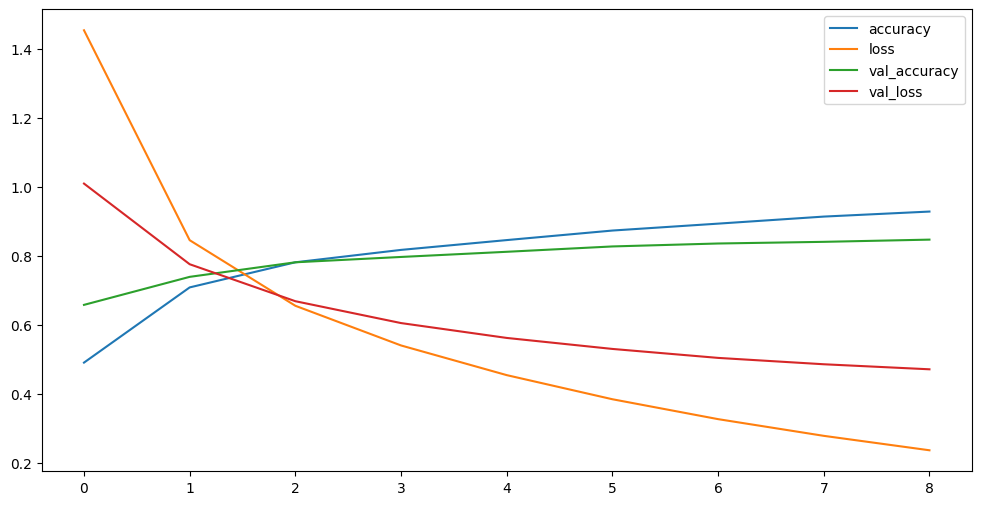

In [23]:
plotHistory(model_1_history)

For our second model, we attempt 512 -> 256 -> 128 -> 64 units in our 4 layers.

In [24]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])

print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=20, optimizer='adam')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4176 - loss: 1.6194 - val_accuracy: 0.6257 - val_loss: 1.1059
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6232 - loss: 1.0996 - val_accuracy: 0.7208 - val_loss: 0.8286
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6927 - loss: 0.9023 - val_accuracy: 0.7603 - val_loss: 0.7277
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7441 - loss: 0.7902 - val_accuracy: 0.7822 - val_loss: 0.6464
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.6922 - val_accuracy: 0.8062 - val_loss: 0.5883
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.6106 - val_accuracy: 0.8163 - val_loss: 0.5801
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8170 - loss: 0.5346 - val_accuracy: 0.8254 - val_loss: 0.5115
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8338 - loss: 0.5016 - val_accuracy: 0.8398 - val_

Maximum Validation Accuracy 0.8937533497810364


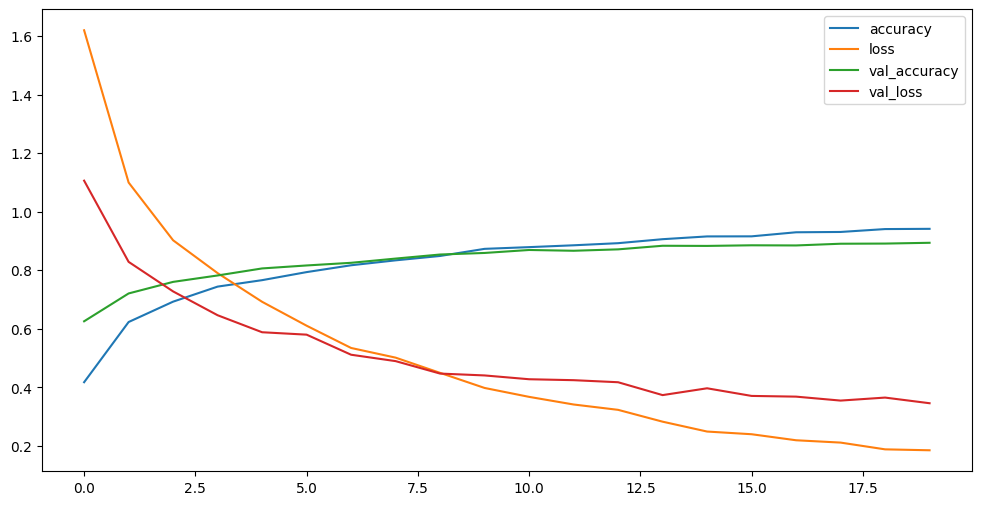

In [25]:
plotHistory(model_2_history)

In our third model, we keep the number of layers the same, but we increase the number of epochs.

In [26]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=290, optimizer='sgd')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1551 - loss: 2.2822 - val_accuracy: 0.3150 - val_loss: 2.1765
Epoch 2/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2547 - loss: 2.1600 - val_accuracy: 0.3545 - val_loss: 2.0411
Epoch 3/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3117 - loss: 2.0310 - val_accuracy: 0.3748 - val_loss: 1.8963
Epoch 4/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3472 - loss: 1.9062 - val_accuracy: 0.3962 - val_loss: 1.7577
Epoch 5/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3797 - loss: 1.7869 - val_accuracy: 0.4298 - val_loss: 1.6418
Epoch 6/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3920 - loss: 1.7053 - val_accuracy: 0.4629 - val_loss: 1.5536
Epoch 7/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4092 - loss: 1.6450 - val_accuracy: 0.4736 - val_loss: 1.4854
Epoch 8/290
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4266 - loss: 1.5884 - val_accuracy: 0.493

Maximum Validation Accuracy 0.9006940722465515


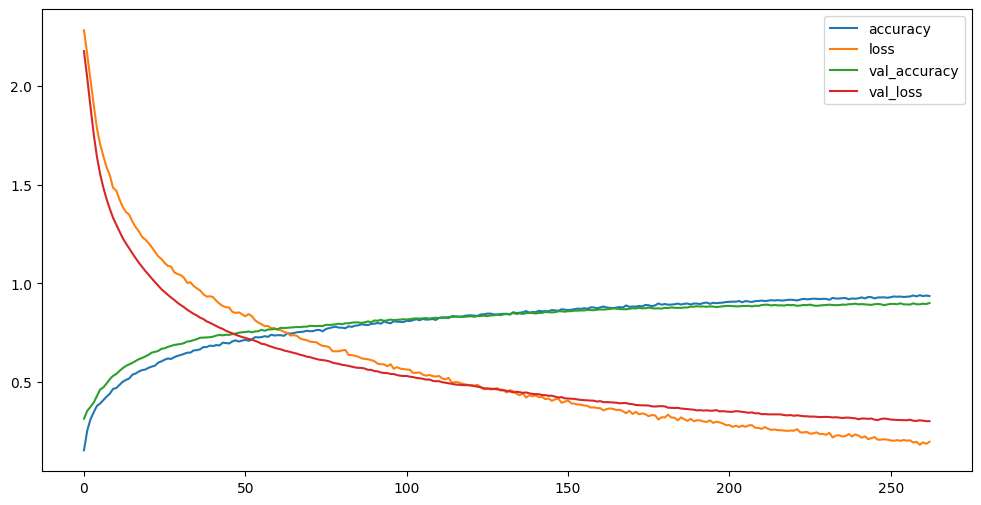

In [27]:
plotHistory(model_3_history)

In our 4th model, we attempt to use 1024 -> 512 -> 256 -> 128 -> 64 units in our layers.

In [28]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=30, optimizer='rmsprop')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1024)           │        59,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,322 (2.89 MB)

 Trainable params: 757,322 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3891 - loss: 1.7062 - val_accuracy: 0.5857 - val_loss: 1.2082
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5655 - loss: 1.2593 - val_accuracy: 0.6903 - val_loss: 0.9310
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6618 - loss: 1.0167 - val_accuracy: 0.7213 - val_loss: 0.8309
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7106 - loss: 0.8848 - val_accuracy: 0.7459 - val_loss: 0.7877
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7503 - loss: 0.7767 - val_accuracy: 0.7806 - val_loss: 0.6714
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7796 - loss: 0.6976 - val_accuracy: 0.7747 - val_loss: 0.6927
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8058 - loss: 0.6214 - val_accuracy: 0.8003 - val_loss: 0.6120
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8213 - loss: 0.5593 - val_accuracy: 0.7987 - val_

Maximum Validation Accuracy 0.9145755767822266


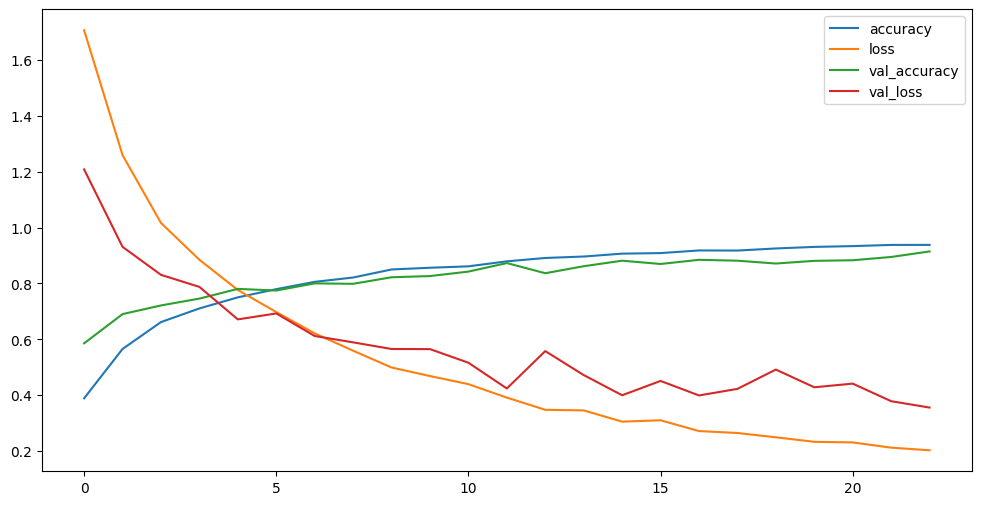

In [29]:
plotHistory(model_4_history)

In [30]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8768 - loss: 0.4537
The test Loss is : 0.45365214347839355

The Best test Accuracy is : 87.6800000667572


### Spectrogram and Training CNN

This next portion converts our audio files into spectrograms, which are then used to train a neural network for music genre classification.

In [31]:
import os
from sklearn.model_selection import train_test_split

In [32]:
tf.config.run_functions_eagerly(True)

def create_spectrogram(file_path, img_size=(128, 128), augment=False):
    try:
        y, sr = librosa.load(file_path, duration=30)  # load first 30 seconds
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # convert to dB
        # normalize to [0, 1]
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_spec_db = tf.image.resize(mel_spec_db[..., np.newaxis], img_size).numpy().squeeze()
        
        if augment:
            # milder time and frequency masking (5% instead of 10%)
            if (np.random.rand() > 0.5):
                max_mask = int(mel_spec_db.shape[1] * 0.05)
                t_start = np.random.randint(0, mel_spec_db.shape[1] - max_mask)
                mel_spec_db[:, t_start:t_start + max_mask] = 0
            if (np.random.rand() > 0.5):
                max_mask = int(mel_spec_db.shape[0] * 0.05)
                f_start = np.random.randint(0, mel_spec_db.shape[0] - max_mask)
                mel_spec_db[f_start:f_start + max_mask, :] = 0
        
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

genres_path = 'data/genres_original'
data = []
labels = []
img_size = (128, 128)
genres = os.listdir(genres_path)

for genre in genres:
    genre_path = os.path.join(genres_path, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_path = os.path.join(genre_path, file)
            spec = create_spectrogram(file_path, img_size, augment=True)
            if spec is not None:
                data.append(spec)
                labels.append(genre)

# Convert to arrays
X_cnn = np.array(data)[..., np.newaxis]  # Add channel dimension
y_cnn = np.array([label_index[l] for l in labels])  # Reuse label_index

# Split data (70% train, ~20% dev, ~10% test)
X_train_cnn, X_test_valid_cnn, y_train_cnn, y_test_valid_cnn = train_test_split(
    X_cnn, y_cnn, train_size=0.7, random_state=42, stratify=y_cnn
)
X_dev_cnn, X_test_cnn, y_dev_cnn, y_test_cnn = train_test_split(
    X_test_valid_cnn, y_test_valid_cnn, train_size=0.66, random_state=42, stratify=y_test_valid_cnn
)

print(f"CNN Train set: {X_train_cnn.shape[0]} samples")
print(f"CNN Dev set: {X_dev_cnn.shape[0]} samples")
print(f"CNN Test set: {X_test_cnn.shape[0]} samples")

/var/folders/b0/5zpzyj6d01ldf7ckz3qfk5wc0000gn/T/ipykernel_79170/1153067835.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)  # Load first 30 seconds
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing data/genres_original/jazz/jazz.00054.wav: 
CNN Train set: 699 samples
CNN Dev set: 198 samples
CNN Test set: 102 samples


In [34]:
from tensorflow.keras import layers, models

In [36]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation = 'softmax')
])

cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
cnn_model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data = (X_dev_cnn, y_dev_cnn),
    epochs = 50, batch_size = 32,
    callbacks = [early_stopping], verbose = 1
)

test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"Improved CNN Test Accuracy: {test_acc_cnn*100:.2f}%")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,794 (6.34 MB)

 Trainable params: 1,662,794 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.1087 - loss: 2.3113 - val_accuracy: 0.0960 - val_loss: 2.2929
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.1202 - loss: 2.2936 - val_accuracy: 0.1717 - val_loss: 2.2807
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.1688 - loss: 2.2642 - val_accuracy: 0.1970 - val_loss: 2.2449
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.1888 - loss: 2.2262 - val_accuracy: 0.2475 - val_loss: 2.1779
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.2060 - loss: 2.1812 - val_accuracy: 0.2727 - val_loss: 2.0937
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.2489 - loss: 2.0709 - val_accuracy: 0.3283 - val_loss: 1.9953
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.2675 - loss: 2.0127 - val_accuracy: 0.3131 - val_loss: 1.9332
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.2747 - loss: 1.9540 - val_accuracy: 0.

In [39]:
from sklearn.metrics import accuracy_score, classification_report

In [40]:
# generate predictions
y_pred_cnn = cnn_model.predict(X_test_cnn).argmax(axis = 1)

# classification report
print("CNN Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn, target_names = label_index.keys()))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
CNN Classification Report:
              precision    recall  f1-score   support

       blues       0.29      0.20      0.24        10
   classical       0.90      0.90      0.90        10
     country       0.18      0.20      0.19        10
       disco       0.25      0.36      0.30        11
      hiphop       0.23      0.30      0.26        10
        jazz       0.50      0.70      0.58        10
       metal       0.83      0.91      0.87        11
         pop       0.71      0.50      0.59        10
      reggae       0.83      0.50      0.62        10
        rock       0.33      0.20      0.25        10

    accuracy                           0.48       102
   macro avg       0.51      0.48      0.48       102
weighted avg       0.51      0.48      0.48       102



In [42]:
from sklearn.metrics import confusion_matrix

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


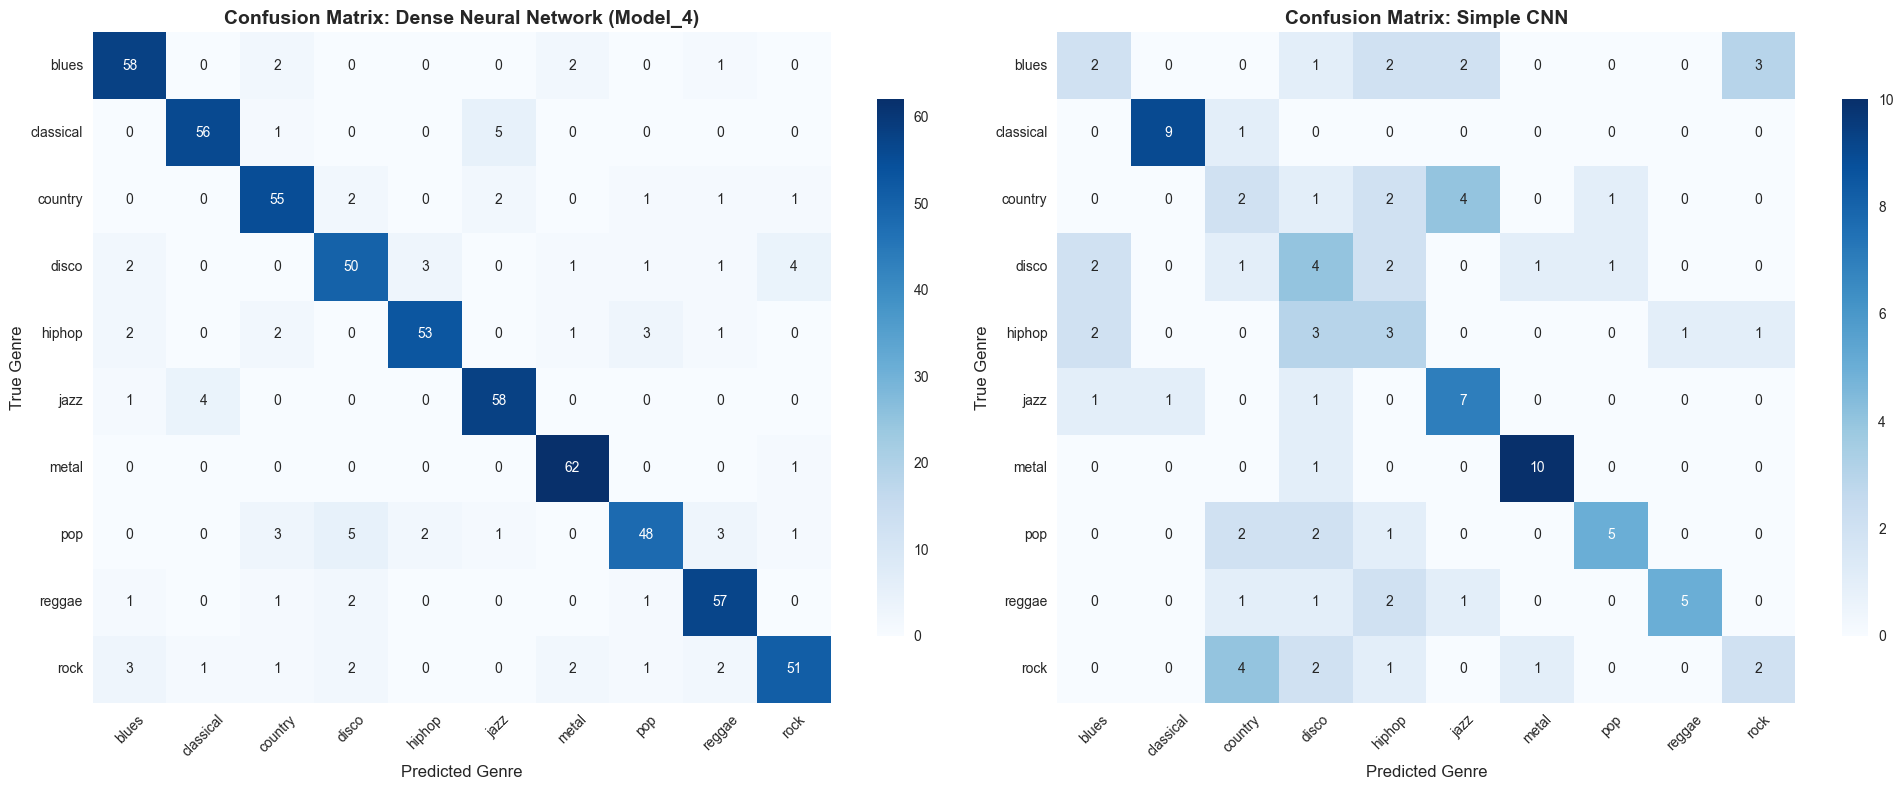

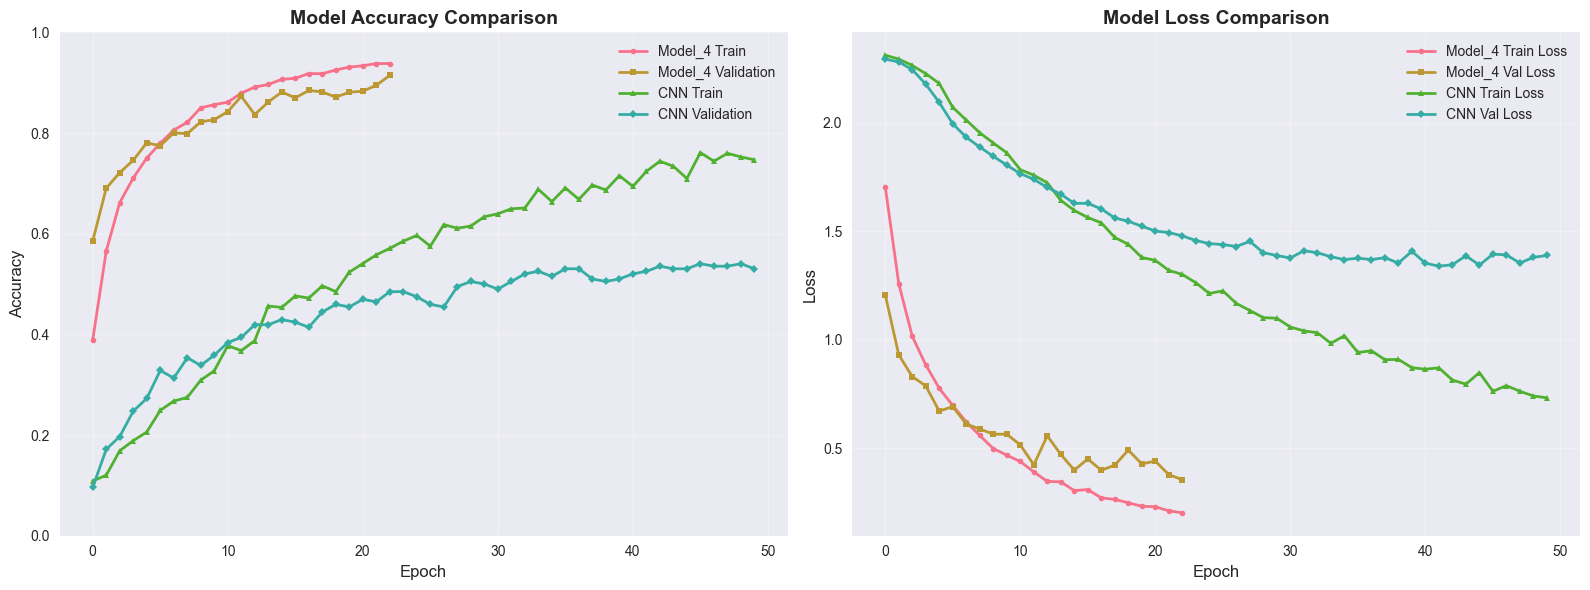

MODEL PERFORMANCE SUMMARY
Dense Neural Network (Model_4) Test Accuracy: 87.68%
Simple CNN Test Accuracy: 48.04%


Classification Report - Dense Neural Network (Model_4)
--------------------------------------------------
              precision    recall  f1-score   support

       blues      0.866     0.921     0.892        63
   classical      0.918     0.903     0.911        62
     country      0.846     0.887     0.866        62
       disco      0.820     0.806     0.813        62
      hiphop      0.914     0.855     0.883        62
        jazz      0.879     0.921     0.899        63
       metal      0.912     0.984     0.947        63
         pop      0.873     0.762     0.814        63
      reggae      0.864     0.919     0.891        62
        rock      0.879     0.810     0.843        63

    accuracy                          0.877       625
   macro avg      0.877     0.877     0.876       625
weighted avg      0.877     0.877     0.876       625


Classification Repor

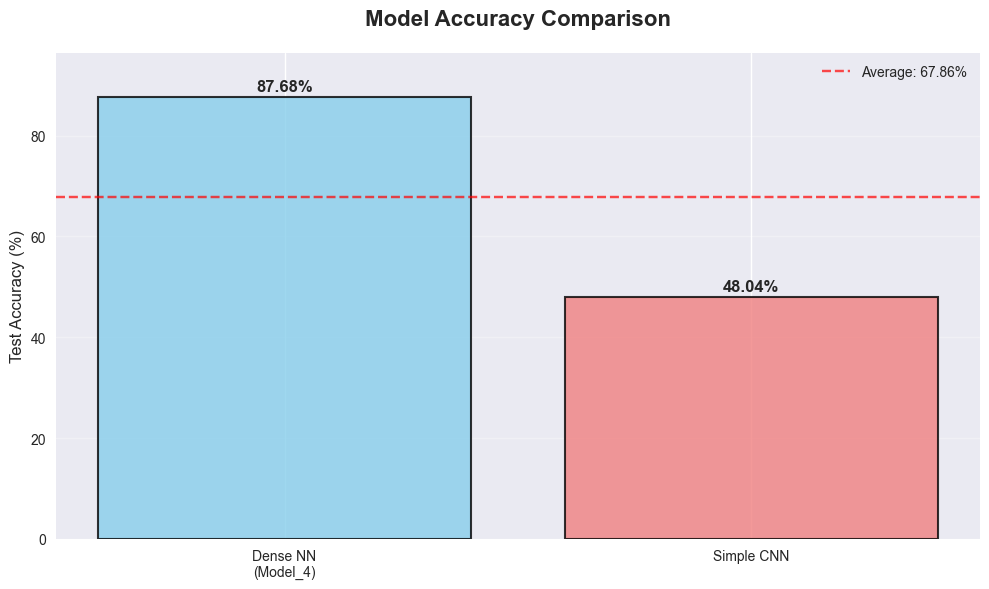


PER-CLASS PERFORMANCE ANALYSIS

Dense Neural Network (Model_4):
------------------------------
blues          :  92.06%
classical      :  90.32%
country        :  88.71%
disco          :  80.65%
hiphop         :  85.48%
jazz           :  92.06%
metal          :  98.41%
pop            :  76.19%
reggae         :  91.94%
rock           :  80.95%

Simple CNN:
----------
blues          :  20.00%
classical      :  90.00%
country        :  20.00%
disco          :  36.36%
hiphop         :  30.00%
jazz           :  70.00%
metal          :  90.91%
pop            :  50.00%
reggae         :  50.00%
rock           :  20.00%


In [43]:
plt.style.use('seaborn-v0_8')  # or just 'seaborn' in older versions
sns.set_palette("husl")

# Predictions for Model_4 (tabular)
y_pred_model_4 = model_4.predict(X_test, batch_size=128).argmax(axis=1)

# Ensure consistent label names (reuse label_index from tabular code)
genres = list(label_index.keys())

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

models_data = [
    ("Dense Neural Network (Model_4)", y_test, y_pred_model_4),
    ("Simple CNN", y_test_cnn, y_pred_cnn)
]

# Plot confusion matrices
for idx, (name, y_true, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_true, y_pred)
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True,           # Show numbers in cells
                fmt='d',              # Integer format
                cmap='Blues',         # Color scheme
                xticklabels=genres,   # X-axis labels
                yticklabels=genres,   # Y-axis labels
                ax=axes[idx],         # Specify subplot
                cbar_kws={'shrink': 0.8})  # Colorbar size
    
    axes[idx].set_title(f'Confusion Matrix: {name}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted Genre', fontsize=12)
    axes[idx].set_ylabel('True Genre', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Training history comparison
history_df_model_4 = pd.DataFrame(model_4_history.history)
history_df_cnn = pd.DataFrame(cnn_history.history)

# Create training history plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy
ax1.plot(history_df_model_4.index, history_df_model_4['accuracy'], 
         label='Model_4 Train', linewidth=2, marker='o', markersize=4)
ax1.plot(history_df_model_4.index, history_df_model_4['val_accuracy'], 
         label='Model_4 Validation', linewidth=2, marker='s', markersize=4)
ax1.plot(history_df_cnn.index, history_df_cnn['accuracy'], 
         label='CNN Train', linewidth=2, marker='^', markersize=4)
ax1.plot(history_df_cnn.index, history_df_cnn['val_accuracy'], 
         label='CNN Validation', linewidth=2, marker='D', markersize=4)

ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot loss (if available)
if 'loss' in history_df_model_4.columns:
    ax2.plot(history_df_model_4.index, history_df_model_4['loss'], 
             label='Model_4 Train Loss', linewidth=2, marker='o', markersize=4)
    ax2.plot(history_df_model_4.index, history_df_model_4['val_loss'], 
             label='Model_4 Val Loss', linewidth=2, marker='s', markersize=4)
    ax2.plot(history_df_cnn.index, history_df_cnn['loss'], 
             label='CNN Train Loss', linewidth=2, marker='^', markersize=4)
    ax2.plot(history_df_cnn.index, history_df_cnn['val_loss'], 
             label='CNN Val Loss', linewidth=2, marker='D', markersize=4)
    
    ax2.set_title('Model Loss Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Dense Neural Network (Model_4) Test Accuracy: {test_acc*100:.2f}%")
print(f"Simple CNN Test Accuracy: {test_acc_cnn*100:.2f}%")
print()

# Detailed classification reports
for name, y_true, y_pred in models_data:
    print(f"\nClassification Report - {name}")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=genres, digits=3))

# Performance comparison bar chart
model_names = ['Dense NN\n(Model_4)', 'Simple CNN']
accuracies = [test_acc * 100, test_acc_cnn * 100]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, 
               color=['skyblue', 'lightcoral'], 
               edgecolor='black', 
               linewidth=1.5,
               alpha=0.8)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.ylim(0, max(accuracies) * 1.1)
plt.grid(axis='y', alpha=0.3)

# Add a horizontal line for average performance
avg_acc = np.mean(accuracies)
plt.axhline(y=avg_acc, color='red', linestyle='--', alpha=0.7, 
            label=f'Average: {avg_acc:.2f}%')
plt.legend()

plt.tight_layout()
plt.show()

# Additional insight: Per-class accuracy
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*60)

for name, y_true, y_pred in models_data:
    print(f"\n{name}:")
    print("-" * len(name))
    
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
    
    for genre, acc in zip(genres, per_class_acc):
        print(f"{genre:15}: {acc:6.2f}%")